Adapted from:

https://github.com/bentrevett/pytorch-sentiment-analysis/blob/main/2%20-%20Recurrent%20Neural%20Networks.ipynb

In [3]:
import pandas as pd
import numpy as np

import torch
import torch.nn.functional as F
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import re

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import matplotlib.pyplot as plt

In [4]:
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_rus to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |  

True

In [7]:
!unzip /root/nltk_data/corpora/wordnet.zip -d /content/nltk_data/corpora/

Archive:  /root/nltk_data/corpora/wordnet.zip
   creating: /content/nltk_data/corpora/wordnet/
  inflating: /content/nltk_data/corpora/wordnet/lexnames  
  inflating: /content/nltk_data/corpora/wordnet/data.verb  
  inflating: /content/nltk_data/corpora/wordnet/index.adv  
  inflating: /content/nltk_data/corpora/wordnet/adv.exc  
  inflating: /content/nltk_data/corpora/wordnet/index.verb  
  inflating: /content/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /content/nltk_data/corpora/wordnet/data.adj  
  inflating: /content/nltk_data/corpora/wordnet/index.adj  
  inflating: /content/nltk_data/corpora/wordnet/LICENSE  
  inflating: /content/nltk_data/corpora/wordnet/citation.bib  
  inflating: /content/nltk_data/corpora/wordnet/noun.exc  
  inflating: /content/nltk_data/corpora/wordnet/verb.exc  
  inflating: /content/nltk_data/corpora/wordnet/README  
  inflating: /content/nltk_data/corpora/wordnet/index.sense  
  inflating: /content/nltk_data/corpora/wordnet/data.noun  
  inflat

In [9]:
df = pd.read_csv('/content/Twitter_Data.csv')
df = df.dropna()

# Split the data into training and validation sets
training_data, validation_data = train_test_split(df, test_size=0.2, random_state=71)

columns = ["content", "sentiment"]
training_data.columns = columns
validation_data.columns = columns

In [10]:
training_data["sentiment"].unique()

array([-1.,  1.,  0.])

### Pre processing

In [11]:
lb = LabelEncoder()
training_data["label_sentiment"] = lb.fit_transform(training_data["sentiment"])
validation_data["label_sentiment"] = lb.fit_transform(validation_data["sentiment"])

In [12]:
training_data.head()

,content,sentiment,label_sentiment
139104,\nmodi trouble this bahihal episode will drag ...,-1.0,0
78115,what else can expect frm these liberandus how ...,1.0,2
91751,the modi governments intention and the timings...,1.0,2
119404,good one,1.0,2
108102,pushan where listen that modi has taken all cr...,0.0,1


In [13]:
training_data.isnull().sum()

content            0
sentiment          0
label_sentiment    0
dtype: int64

In [14]:
training_data.dropna(inplace=True)

In [15]:
training_data.isnull().sum()

content            0
sentiment          0
label_sentiment    0
dtype: int64

In [16]:
lb.classes_

array([-1.,  0.,  1.])

In [17]:
training_data["sentiment"].value_counts()

sentiment
 1.0    54168
 0.0    41574
-1.0    26750
Name: count, dtype: int64

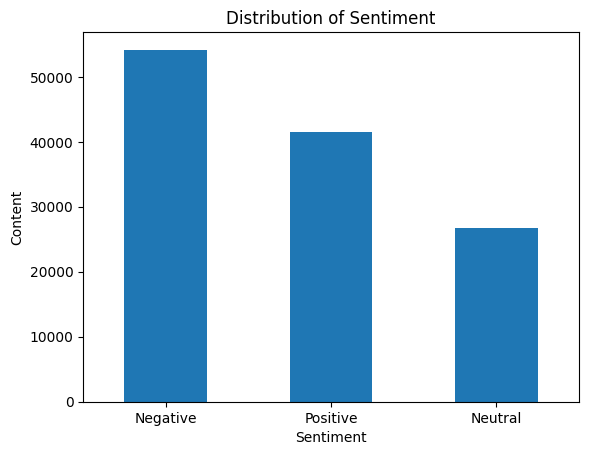

In [18]:
value_counts = training_data["sentiment"].value_counts()
ax = value_counts.plot(kind='bar')

ax.set_xticklabels(['Negative', 'Positive', 'Neutral'], rotation=0)

plt.title('Distribution of Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Content')

plt.show()

In [19]:
nltk.download('wordnet')
nltk.download('stopwords')
wnl = WordNetLemmatizer()
stop_words = stopwords.words('english')

def preprocessing_text(text):
    text = re.sub('[^A-Za-z]+', ' ', text)
    text = text.split()
    text = " ".join([wnl.lemmatize(word) for word in text if not word in stop_words and len(word) >= 3])
    return text.lower()


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
training_data["content"] = training_data["content"].apply(preprocessing_text)

In [21]:
training_data.head()

,content,sentiment,label_sentiment
139104,modi trouble bahihal episode drag nearabout ca...,-1.0,0
78115,else expect frm liberandus true anti modi beco...,1.0,2
91751,modi government intention timing questionable ...,1.0,2
119404,good one,1.0,2
108102,pushan listen modi taken credit guess need che...,0.0,1


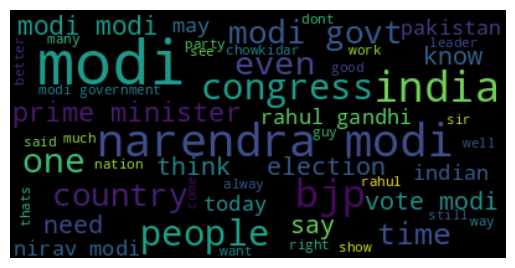

In [22]:
from PIL import Image
from wordcloud import WordCloud

text = " ".join(training_data["content"])

wordcloud = WordCloud(max_font_size=50, max_words=50, background_color="blacK").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [23]:
from random import randint

x = randint(0, training_data.shape[0])

training_data.iloc[x:x+5, :]

,content,sentiment,label_sentiment
53961,security related message clearly exposing modi...,1.0,2
112689,good frank answer many doubt cleared modi,1.0,2
128335,objection filed rastrawad become issue modi sa...,0.0,1
25802,still plagued problem even term bjd rule enoug...,1.0,2
65948,chutiye say nothing show dallas never understa...,-1.0,0


### Modeling

In [24]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [25]:
def get_vocab(X):
    vocab = {'__UNK__': 0}

    for item in X:
        for word in item.split():
            if word not in vocab:
                vocab[word] = len(vocab)

    return vocab

vocab = get_vocab(training_data["content"])

In [26]:
print(len(vocab))

79688


In [27]:
def text_to_tensor(text, unk_token='__UNK__'):

    tensor = [0] * 130

    for e, word in enumerate(text.split()):
        if not word in vocab:
            word = unk_token

        tensor[e] = vocab[word]

    return tensor

In [28]:
m = 0

list_x = training_data["content"].values

for i in range(training_data["content"].shape[0]):
    if len(text_to_tensor(list_x[i])) > m:
        m = len(text_to_tensor(list_x[i]))

print(m)

130


In [29]:
X = list(training_data["content"].apply(text_to_tensor))
y = list(training_data["label_sentiment"])

In [30]:
X_train = training_data["content"].values
y_train = training_data["label_sentiment"].values

X_test = validation_data["content"].values
y_test = validation_data["label_sentiment"].values

In [31]:
# Convert text data to numerical representations first
X_train_tensor = torch.tensor([text_to_tensor(text) for text in X_train])
y_train_tensor = torch.tensor(y_train)  # Now convert to tensor

# Move tensors to the desired device
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)

# Create TensorDataset and DataLoader
train_data = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_data, batch_size=2, shuffle=True)

In [32]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("train_data length:", len(train_data))

X_train shape: (122492,)
y_train shape: (122492,)
train_data length: 122492


In [33]:
X_test_tensor = torch.tensor([text_to_tensor(text) for text in X_test])
y_test_tensor = torch.tensor(y_test)

# Move tensors to the desired device
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

# Create TensorDataset and DataLoader
test_data = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_data, batch_size=2, shuffle=True)

In [34]:
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
print("test_data length:", len(test_data))

X_test shape: (30624,)
y_test shape: (30624,)
test_data length: 30624


In [35]:
def train(model, optimizer, criterion, num_epochs):
    train_loss = []
    train_accuracy = []

    for epoch in range(num_epochs):
        model.train()
        total_correct = 0
        total_samples = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs).to(device)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

        accuracy = total_correct / total_samples
        train_loss.append(loss.item())
        train_accuracy.append(accuracy * 100)

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}, Accuracy: {accuracy * 100:.2f}%')

In [36]:
def test(model):

    total_correct = 0
    total_samples = 0
    for inputs, labels in test_loader:
        outputs = model(inputs).to(device)
        loss = criterion(outputs, labels)

        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    accuracy = total_correct / total_samples

    print(f'Loss: {loss.item()}, Accuracy: {accuracy * 100:.2f}%')

### Model 1

In [72]:
class SimpleNLPModel(nn.Module):
    def __init__(self, vocab_size, embed_size, num_classes):
        super(SimpleNLPModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.fc = nn.Linear(embed_size, num_classes)

    def forward(self, x):
        embedded = self.embedding(x)
        pooled = torch.mean(embedded, dim=1)
        out = self.fc(pooled)
        return out

In [73]:
vocab_size = len(vocab) + 1
embed_size = 50
num_classes = training_data["sentiment"].nunique()

In [74]:
model = SimpleNLPModel(vocab_size, embed_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [75]:
train(model, optimizer, criterion, num_epochs=20)

Epoch 1/20, Loss: 0.11392629146575928, Accuracy: 81.01%
Epoch 2/20, Loss: 0.15131577849388123, Accuracy: 88.62%
Epoch 3/20, Loss: 0.12129803001880646, Accuracy: 90.06%
Epoch 4/20, Loss: 0.1025448888540268, Accuracy: 90.74%
Epoch 5/20, Loss: 0.05750105902552605, Accuracy: 91.30%
Epoch 6/20, Loss: 0.12226132303476334, Accuracy: 91.58%
Epoch 7/20, Loss: 0.1247766986489296, Accuracy: 91.89%
Epoch 8/20, Loss: 0.015017382800579071, Accuracy: 92.05%
Epoch 9/20, Loss: 0.03733424097299576, Accuracy: 92.26%
Epoch 10/20, Loss: 0.09697923064231873, Accuracy: 92.33%
Epoch 11/20, Loss: 0.10151790082454681, Accuracy: 92.43%
Epoch 12/20, Loss: 0.17569264769554138, Accuracy: 92.57%
Epoch 13/20, Loss: 0.08019296079874039, Accuracy: 92.62%
Epoch 14/20, Loss: 0.0047206031158566475, Accuracy: 92.74%
Epoch 15/20, Loss: 0.03156685084104538, Accuracy: 92.78%
Epoch 16/20, Loss: 0.09627455472946167, Accuracy: 92.84%
Epoch 17/20, Loss: 0.07961351424455643, Accuracy: 92.92%
Epoch 18/20, Loss: 0.029713507741689682

In [81]:
test(model)

Loss: 0.038807760924100876, Accuracy: 87.70%


### Model 2

In [39]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_size, num_classes, hidden_size, num_layers, dropout):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        lstm_out = self.dropout(lstm_out)
        lstm_out = torch.mean(lstm_out, dim=1)
        output = self.fc(lstm_out)

        return output

In [40]:
vocab_size = len(vocab) + 1
embed_size = 100
num_classes = training_data["sentiment"].nunique()
hidden_size = 128
num_layers = 3
dropout = 0.5

In [41]:
lstm_model = LSTMModel(vocab_size, embed_size, num_classes, hidden_size, num_layers, dropout).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)

In [42]:
train(lstm_model, optimizer, criterion, num_epochs=20)

Epoch 1/20, Loss: 0.022531814873218536, Accuracy: 80.21%
Epoch 2/20, Loss: 0.22552859783172607, Accuracy: 89.16%
Epoch 3/20, Loss: 0.06024133786559105, Accuracy: 90.81%
Epoch 4/20, Loss: 0.21808457374572754, Accuracy: 91.82%
Epoch 5/20, Loss: 0.11497274786233902, Accuracy: 92.53%
Epoch 6/20, Loss: 0.020003367215394974, Accuracy: 92.98%
Epoch 7/20, Loss: 0.031949158757925034, Accuracy: 93.42%
Epoch 8/20, Loss: 0.005733974277973175, Accuracy: 93.74%
Epoch 9/20, Loss: 1.580161213874817, Accuracy: 93.87%
Epoch 10/20, Loss: 2.1859827041625977, Accuracy: 94.13%
Epoch 11/20, Loss: 0.896119236946106, Accuracy: 94.25%
Epoch 12/20, Loss: 0.0015721987001597881, Accuracy: 94.41%
Epoch 13/20, Loss: 2.075084686279297, Accuracy: 94.57%
Epoch 14/20, Loss: 0.006412642542272806, Accuracy: 94.65%
Epoch 15/20, Loss: 0.045771144330501556, Accuracy: 94.83%
Epoch 16/20, Loss: 0.03045845590531826, Accuracy: 94.93%
Epoch 17/20, Loss: 1.4086676836013794, Accuracy: 95.00%
Epoch 18/20, Loss: 0.020982801914215088,

In [44]:
test(lstm_model)

Loss: 0.002003295347094536, Accuracy: 86.44%
